In [3]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf


In [82]:
'''
Builds 3-layer nnet - last layer is used as basis for bayesian linear inference

'''


def model():
    
    dim_input = 1
    n_hidden1 = 10
    n_hidden2 = 35
    n_hidden3 = 30
    dim_output = 1
    
    x_in = tf.placeholder(tf.float32, shape = [None,1],name="inputCMON")
    #x_inn = tf.Variable(x_in, validate_shape=False)
    #x_inn = tf.Variable([1.0],name = "wrtin")
    x_inn = x_in
    
    #x_inn = tf.assign(x_inn,x_in, validate_shape=False)
    
    w1 = tf.Variable(tf.truncated_normal([dim_input,n_hidden1]))
    b1 = tf.Variable(tf.zeros([n_hidden1]))
    l1 = tf.nn.sigmoid(tf.matmul(x_inn,w1) + b1)
    
    w2 = tf.Variable(tf.truncated_normal([n_hidden1,n_hidden2]))
    b2 = tf.Variable(tf.zeros([n_hidden2]))
    l2 = tf.nn.sigmoid(tf.matmul(l1,w2) + b2)
    
    w3 = tf.Variable(tf.truncated_normal([n_hidden2,n_hidden3]))
    b3 = tf.Variable(tf.zeros([n_hidden3]))
    l3 = tf.nn.sigmoid(tf.matmul(l2,w3) + b3)
    
    w4 = tf.Variable(tf.truncated_normal([n_hidden3,dim_output]))
    b4 = tf.Variable(tf.zeros([dim_output]))
    y_pred = tf.matmul(l3,w4) 
    
  
    basis = l3
    params = w4
    
    return x_in, x_inn, y_pred, l3

'''
train function to learn prior values of 

'''
    
def train(xin, out, x_train,y_train, n_epochs, sess):
    
    Y_train = tf.placeholder(tf.float32, shape=[None,1], name="yyy")
    MSEloss = tf.reduce_mean(tf.square(Y_train-out))
    train = tf.train.AdamOptimizer().minimize(MSEloss)
    init_op = tf.initialize_all_variables()
    sess.run(init_op) #feed_dict = {xin:np.asarray([[1.0]])})
    
    for i in range(n_epochs):        
        sess.run(train, feed_dict = {xin:np.reshape(x_train,(-1,1)), Y_train: np.reshape(y_train,(-1,1))})

    
    
    
    

In [83]:

def objective(x):
    y = x**2+x**3;
    return y 

#train data
#x_train = np.linspace(-5,5,10)
x_train = np.array([-7.0,-6.0,-5.0,0.0,3.0,7.0])
np.random.shuffle(x_train)
y_train = objective(x_train)

x_train = np.reshape(x_train, (-1,1))
y_train = np.reshape(y_train, (-1,1))

#test data
xtest = np.linspace(-12.0,12.0,10)
ytest = objective(xtest)

xtest = np.reshape(xtest,(-1,1))
ytest = np.reshape(ytest,(-1,1))



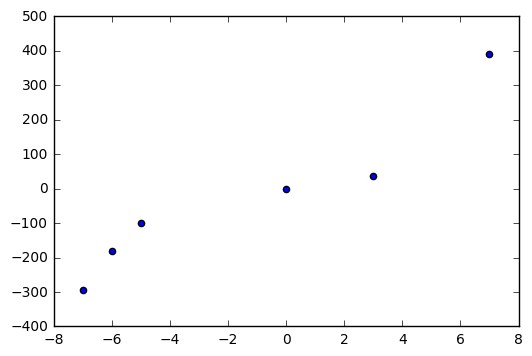

In [84]:
plt.scatter(x_train,y_train)


In [85]:
class posterior():
    #3 pages of math later...
    # a = 1/var(data) b = 1/var(params)  
    #mu 
    #dim(map_params) = (1,x_features)
    #dim(A) = (numtrain, x_features), dim(xtest) = (x_features, 1), dim(ytrain) = (numtrain,1)
    #dim(Av) = (x_features, x_features), dim(lambda_pos)=(1)
    
    
    
    
    def __init__(self, basis, xplaceholder, xinn, xtrain, ytrain,a,b, sess):
        #A = sess.run(basis, feed_dict = {})
        #make A
        self._xinn = xinn
        self._xtest= 0
        self._a = a
        self._b = b
        self._sess = sess
        self._basis = basis
        self._xplaceholder = xplaceholder
        iden = tf.Variable(initial_value = np.identity(30))
        iden =  tf.cast(iden, tf.float32)
        self._objjj = tf.cast(tf.Variable(1.0),tf.float64)

        sess.run(tf.initialize_all_variables())
        
        self._A = sess.run(basis, feed_dict = {xplaceholder:xtrain})  
        #self._A2 = sess.run(basis, feed_dict = {xplaceholder:xtrain})  
        #tf.print_function(print(self._A))
        
        self._Av = tf.matrix_inverse(self._a*tf.matmul(tf.transpose(self._A),self._A) + (self._b)*(self._b)*iden)
        self._A = tf.cast(self._A, tf.float64)
        self._Av = tf.cast(self._Av, tf.float64)
        self._map_params = tf.matmul(tf.matmul(self._Av, tf.transpose(self._A)),ytrain)
        
        self._sample_min = 0  #TODO 
        #self._map_params = self._a*tf.matmul(tf.matmul(tf.matrix_inverse(self._Av),tf.transpose(self._A)), ytrain)
        #self._map_params = tf.transpose(self._map_params)
        #(numfeatures, 1)

    def predict(self, xtest):
        self._xtesta = xtest
        self._xtest = self._basis#self._sess.run(self._basis, feed_dict = {self._xplaceholder:self._xtesta})
        self._xtest = tf.cast(self._xtest, tf.float64)
        s1 = tf.matmul(self._xtest, self._Av)
        self._phiK = tf.matmul(self._Av, tf.transpose(self._xtest)) #(num dim, num samples)
        #lambd_pos =  (1/self._a) + tf.mul(tf.transpose(xtest), self._phiK),0)
        self._sig =  (1/self._a) + tf.matmul(s1, tf.transpose(self._xtest))
        self._mu_pos = tf.matmul(self._a*self._xtest, self._map_params)
        
        return 1 #(self._sess.run(self._sig, feed_dict = {self._xplaceholder = xtrial, self._mu_pos.eval())
    
    
    
    def acq(self,trialx):
        #self._xtest=trialx
        dist = tf.contrib.distributions.Normal(mu = self._mu_pos[0], sigma=self._sig[0])
        objective_acq = tf.convert_to_tensor(dist.cdf(tf.cast(self._sample_min,tf.float64)))#+2.0 #TODO: add expectation
        opt = tf.train.GradientDescentOptimizer(learning_rate=0.01)
        train_op = opt.minimize(objective_acq,var_list = [self._xinn])
        #self._sess.run(train_op, feed_dict = {self._xplaceholder:trialx})
        return self._sess.run(objective_acq, feed_dict = {self._xplaceholder: trialx})
        #return  self._sess.run(train_op, feed_dict = {self._xplaceholder:trialx})#, feed_dict = {self._xplaceholder:trialx})
        #return np.sum(grad1*grad2), objective_acq.eval()
        #return sess.run(objective_acq,feed_dict = {self._xplaceholder: trialx} )
    def set_sample_min(self,minn):
        self._sample_min = minn
        
        
        


     

In [86]:
grads = np.zeros((len(xtest),1))
y_hat = np.zeros((len(xtest),2))
with tf.Session() as sess:
    xplace,xinn, out, basis = model()
    train(xplace,out,x_train,y_train,1000,sess)
    #aa = sess.run(basis, feed_dict = {xplace:xtest})
    #bayeslinear = posterior(basis, xplace, xinn, x_train, y_train, 8,0.4, sess)
    #y_hat = bayeslinear.predict(np.reshape(xtest, (-1,1)))
    minn = np.min(x_train)
    bayeslinear.set_sample_min(minn)
    for i in range(1):
        print("yo")
        #y_hat[i,:] = bayeslinear.predict(np.reshape(xtest[i],(-1,1)))
        #k=bayeslinear.acq([xtest[i]])#np.reshape(xtest[i],(-1,1)))

InvalidArgumentError: You must feed a value for placeholder tensor 'inputCMON' with dtype float
	 [[Node: inputCMON = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'inputCMON', defined at:
  File "/usr/local/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/anmol/cheng/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/anmol/cheng/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/anmol/cheng/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/anmol/cheng/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/anmol/cheng/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/anmol/cheng/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/anmol/cheng/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/anmol/cheng/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/anmol/cheng/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/anmol/cheng/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/anmol/cheng/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/anmol/cheng/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/anmol/cheng/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/anmol/cheng/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/anmol/cheng/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/anmol/cheng/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/anmol/cheng/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/anmol/cheng/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-dcdabfd7dce9>", line 4, in <module>
    xplace,xinn, out, basis = model()
  File "<ipython-input-4-26acdf8c9046>", line 15, in model
    x_in = tf.placeholder(tf.float32, shape = [None,1],name="inputCMON")
  File "/home/anmol/cheng/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py", line 1332, in placeholder
    name=name)
  File "/home/anmol/cheng/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1748, in _placeholder
    name=name)
  File "/home/anmol/cheng/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 749, in apply_op
    op_def=op_def)
  File "/home/anmol/cheng/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2380, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/anmol/cheng/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1298, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'inputCMON' with dtype float
	 [[Node: inputCMON = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [ ]:
n = len(xtest)
stdv = np.zeros(n)
for i in range(n):
    stdv[i] = np.sqrt(np.abs(y_hat[i,1]))
    


In [110]:
x_train.shape[0]

6

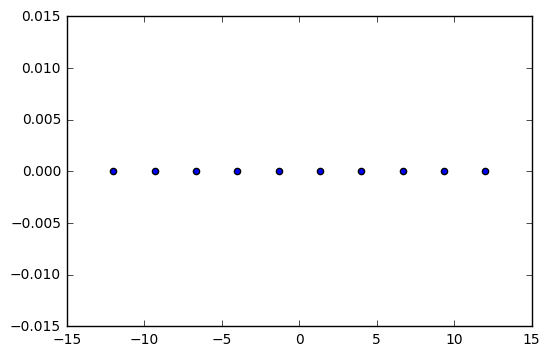

In [42]:
plt.scatter(xtest,grads)

In [346]:
y_hat[:,0]

array([ 0.34557541,  0.23053482,  0.17002583,  0.18313489,  0.25221612,
        0.21660741,  0.18923727,  0.20097663,  0.24408082,  0.30376577])

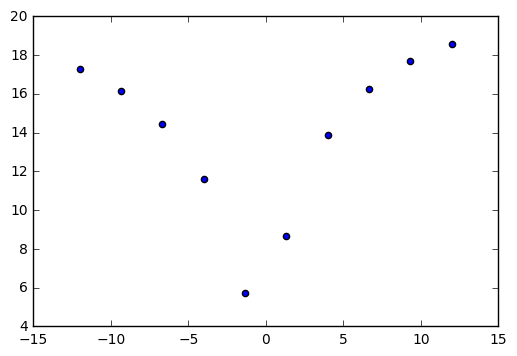

In [352]:
stdv = np.reshape(stdv,(-1,1))
mu = y_hat[:,0]
plt.scatter(xtest,stdv)

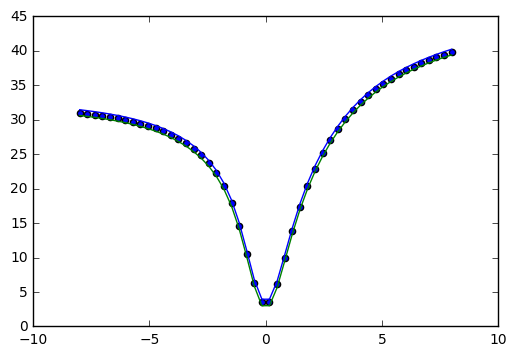

In [210]:
plt.plot(xtest,mu+stdv)
plt.plot(xtest,mu-stdv)
plt.scatter(xtest,mu)

In [211]:
minn = np.min(x_train)
bayeslinear.set_sample_min(minn)
grads = bayeslinear.acq(tf.Session(),xtest)
plt.scatter(xtest, grads)

FailedPreconditionError: Attempting to use uninitialized value Variable_503
	 [[Node: Variable_503/read = Identity[T=DT_DOUBLE, _class=["loc:@Variable_503"], _device="/job:localhost/replica:0/task:0/cpu:0"](Variable_503)]]

Caused by op 'Variable_503/read', defined at:
  File "/usr/local/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/anmol/cheng/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/anmol/cheng/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/anmol/cheng/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/anmol/cheng/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/anmol/cheng/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/anmol/cheng/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/anmol/cheng/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/anmol/cheng/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/anmol/cheng/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/anmol/cheng/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/anmol/cheng/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/anmol/cheng/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/anmol/cheng/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/anmol/cheng/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/anmol/cheng/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/anmol/cheng/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/anmol/cheng/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/anmol/cheng/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-207-0d471b9f129a>", line 5, in <module>
    bayeslinear = posterior(basis, xplace, x_train, y_train, 8,0.4, sess)
  File "<ipython-input-206-65599a13b7d1>", line 21, in __init__
    iden = tf.Variable(initial_value = np.identity(30))
  File "/home/anmol/cheng/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 215, in __init__
    dtype=dtype)
  File "/home/anmol/cheng/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 327, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/home/anmol/cheng/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1128, in identity
    result = _op_def_lib.apply_op("Identity", input=input, name=name)
  File "/home/anmol/cheng/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 749, in apply_op
    op_def=op_def)
  File "/home/anmol/cheng/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2380, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/anmol/cheng/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1298, in __init__
    self._traceback = _extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value Variable_503
	 [[Node: Variable_503/read = Identity[T=DT_DOUBLE, _class=["loc:@Variable_503"], _device="/job:localhost/replica:0/task:0/cpu:0"](Variable_503)]]


In [212]:
grads

[array([[ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.]])]

In [ ]:
from scipy.stats import norm
class acq():    
    def __init__(self, mode = "UCG"):
        self._mode = mode
        
    def EI(self, mu, sd):
        minval = np.min(mu)
        EI_score = np.zeros(len(mu))
        for i in range(len(mu)):
            EI_score[i] = mu[i]/2 + norm.cdf(minval, mu[i], sd[i])           
        return EI_score
    
acqu = acq()
ei = acqu.EI(mu,stdv)
        
        
        
        


In [60]:
np.min(x_train)

-7.0

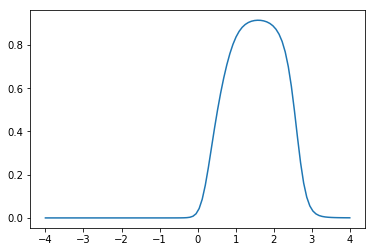

In [ ]:
np.reshape(xtest,(-1,1))[]